In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import joblib
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance
import threading
import concurrent
from sklearn.metrics import r2_score
from VAE_OPTIMIZATION_R2 import _dataset, VAE, study#, compare_distributions_binned_aux, compare_distributions_binned
from VAE_OPTIMIZATION_WD import compare_continuous, compare_integer

[I 2021-07-29 17:33:08,158] Using an existing study with name 'Optimizing the VAE with R2 - BKG vs Reconstruction' instead of creating a new one.
[I 2021-07-29 17:33:08,215] Using an existing study with name 'Optimizing the VAE with WD - BKG vs Random Sampling' instead of creating a new one.


In [2]:
import time
time.sleep(1)

## Loading the Study

In [3]:

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print(" TRIAL NUMBER:", trial.number)

Number of finished trials: 106
Best trial:
  Value: 0.9859930944929812
  Params: 
    alpha: 3051
    hidden_size: 35
    lr: 0.000558675348595003
    n_layers_decoder: 1
    n_layers_encoder: 1
    n_units_decoder_l0: 425
    n_units_encoder_l0: 370
 TRIAL NUMBER: 67


### Optuna Graphs

In [4]:
optuna.visualization.plot_param_importances(study)

In [5]:
optuna.visualization.plot_optimization_history(study)

## Anomaly Detection

### Load the model

In [6]:
#name = "re-reconstruction_vs_data_trial_38" FOI O 38 DA RECONSTRUCTION!!!!!
#name = "r2-reconstruction_vs_data_trial_{}".format(trial.number)
name = "CustomTrain_R2-Data_vs_Reconstruction_trial_67"
model = VAE.load_from_checkpoint(
    #join('models', f"sample_vs_data_trial_{study.best_trial.number}.ckpt"),
    join("models", name + ".ckpt"),
    #trial = study.trials[38], 
    trial = optuna.trial.FixedTrial(study.best_trial.params), 
    dataset = "bkg", 
    batch_size=512)

model.eval()

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [1, 10000] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 9996].

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [5, 500] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 495].



VAE(
  (encoder): Sequential(
    (0): Linear(in_features=69, out_features=370, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=370, out_features=35, bias=True)
  )
  (hidden2mu): Linear(in_features=35, out_features=35, bias=True)
  (hidden2log_var): Linear(in_features=35, out_features=35, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=35, out_features=425, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=425, out_features=69, bias=True)
  )
)

### Load data

In [7]:
# Bkg
bkg = _dataset(category='test',variant='bkg').all_data()
bkg_name = bkg['name']
bkg_weights = bkg['weights']
bkg.drop(columns=['weights', 'name'], inplace=True)
bkg.shape

(341121, 69)

## Check if z ~ N(0,1)

In [8]:
_, _, x_out, hidden = model.test_step(torch.from_numpy(bkg.to_numpy(dtype=np.float32)))
x_out = x_out.detach().numpy()
hidden = hidden.detach().numpy()
hidden.shape

(341121, 35)

<ipython-input-9-cccee3f30eb4>:11: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



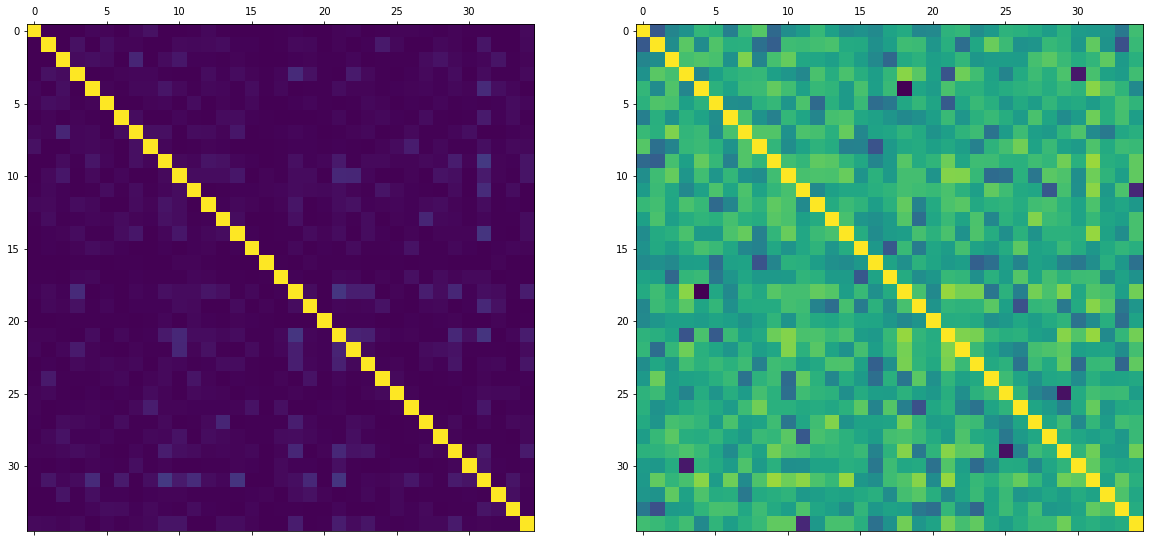

In [9]:
fig = plt.figure(figsize=[20,15])
i = 0

axes = fig.add_subplot(1,2,i+1)
i += 1
axes.matshow(pd.DataFrame(hidden).corr().apply(abs))

axes = fig.add_subplot(1,2,i+1)
i += 1
axes.matshow(pd.DataFrame(hidden).corr().apply(abs).apply(np.log))
fig.show()

In [ ]:
corr = pd.DataFrame(hidden).corr().apply(abs)
corr.replace(1, 0, inplace=True)

print("Max:\t", round(corr.max().max(), 5))
print("Mean:\t", round(corr.mean().mean(), 5))

Max:	 0.16659
Mean:	 0.01764


Mean: 0.060398147 	Std: 0.984405
Mean: -0.025039142 	Std: 0.9750775
Mean: -0.014884721 	Std: 1.0115306
Mean: -0.02028908 	Std: 0.99808383
Mean: -0.022385687 	Std: 0.9991776
Mean: 0.050107792 	Std: 0.9877134
Mean: -0.0097439755 	Std: 0.9868645
Mean: 0.04179383 	Std: 1.0082697
Mean: -0.039216507 	Std: 0.98090166
Mean: 0.049779467 	Std: 1.0219407
Mean: -0.017186804 	Std: 1.0063158
Mean: 0.0071688266 	Std: 0.99719864
Mean: 0.011064412 	Std: 1.0155978
Mean: -0.009928171 	Std: 0.9814296
Mean: -0.03071194 	Std: 0.9868336
Mean: 0.021334376 	Std: 0.9813355
Mean: 0.021677827 	Std: 0.98640627
Mean: -0.010624481 	Std: 0.9887846
Mean: -0.023310699 	Std: 1.0033916
Mean: 0.07204748 	Std: 0.9829927
Mean: 0.019232862 	Std: 0.98752207
Mean: 0.02149729 	Std: 0.9914357
Mean: -0.020956153 	Std: 0.98582375
Mean: 0.010564217 	Std: 0.974415
Mean: -0.033052634 	Std: 0.9892566
Mean: 0.030293256 	Std: 0.98780596
Mean: -0.02200864 	Std: 0.97374
Mean: 0.036497887 	Std: 0.9841313
Mean: 0.056162663 	Std: 0.9934945
M

<ipython-input-9-2870a7d92efa>:14: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



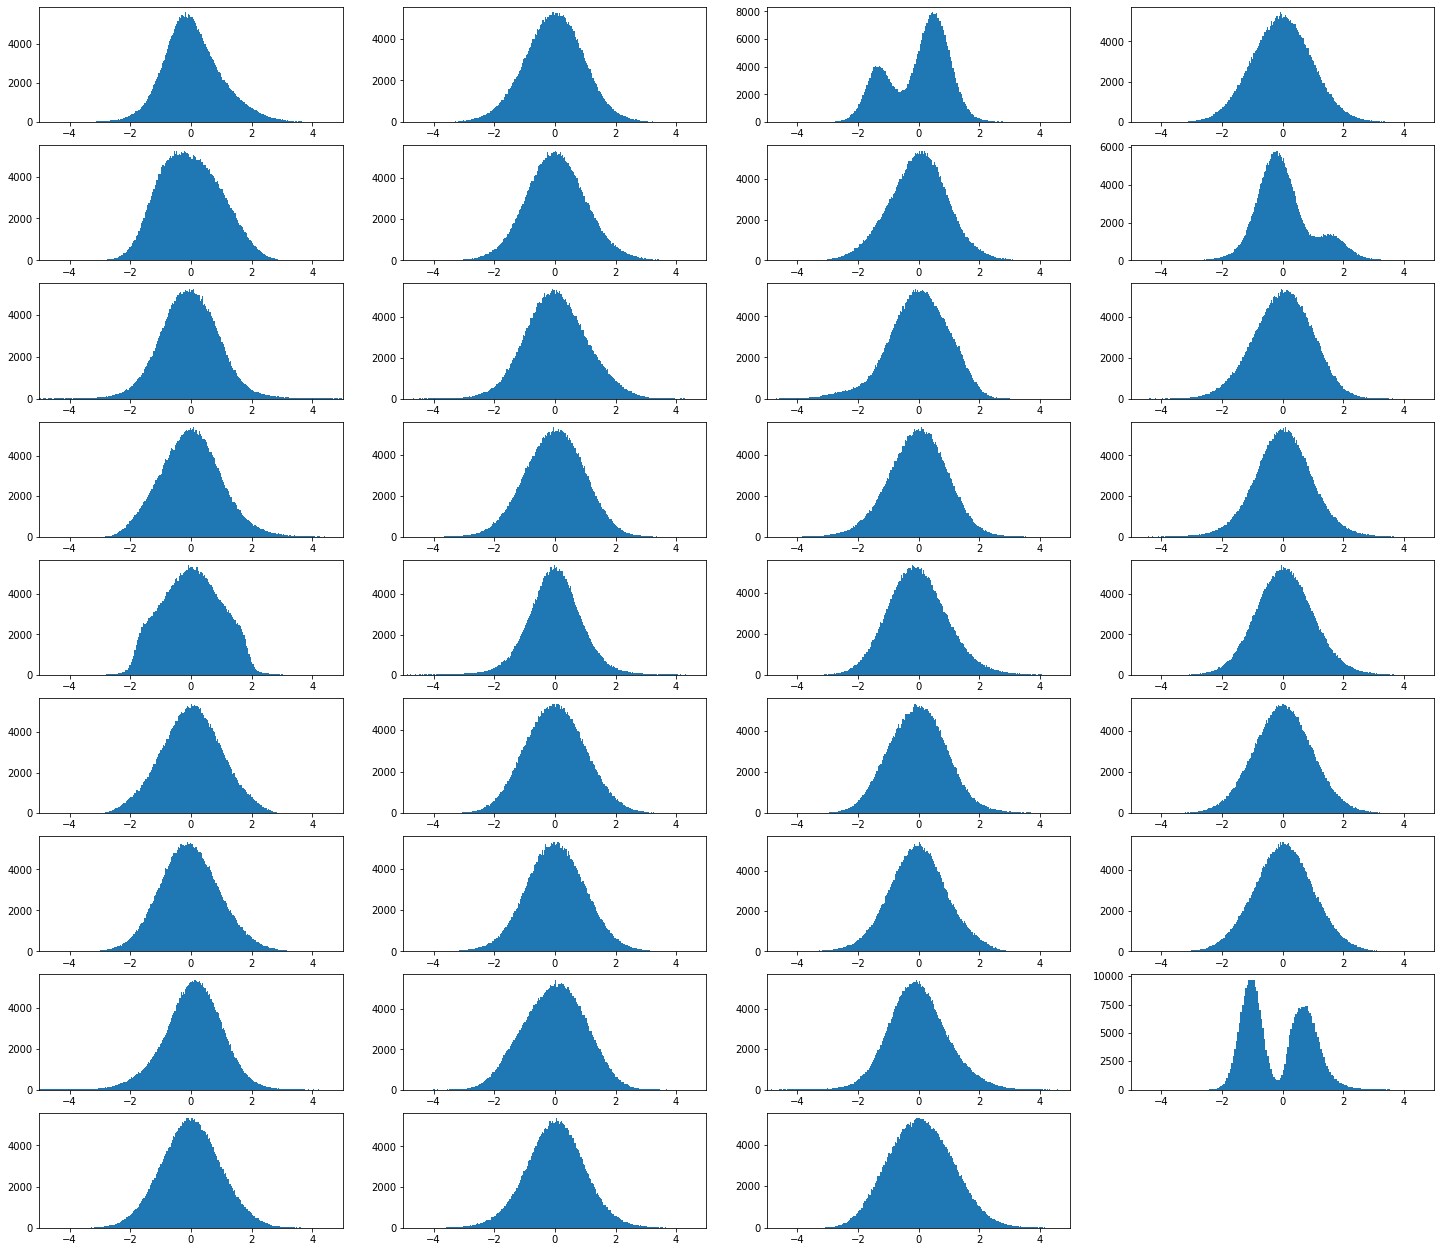

In [9]:

fig = plt.figure(figsize=[25,25])
i = 0

for x in range(hidden.shape[1]):
    axes = fig.add_subplot(10,4,i+1)
    i += 1

    axes.hist(hidden[:, x], bins='auto')
    axes.axis(xmin=-5,xmax=5)
    #axes.title(f"Z{x}")
    print("Mean:", hidden[:, x].mean(), "\tStd:", hidden[:, x].std())


fig.show()

## Bkg Data vs Random Sampling Decoding

In [10]:
# Random sample from N(0,1)
sample = model.decode(torch.rand(bkg.shape[0], study.best_trial.params['hidden_size'])).detach().numpy()

# Make it a dataframe
sample = pd.DataFrame(sample, columns=bkg.columns)
sample.describe()

,Electron1_Eta,Electron1_PT,Electron1_Phi,Electron2_Eta,Electron2_PT,Electron2_Phi,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,...,MissingET_MET,MissingET_Phi,Muon1_Eta,Muon1_PT,Muon1_Phi,Muon2_Eta,Muon2_PT,Muon2_Phi,Muon_Multi,ScalarHT_HT
count,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,...,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000
mean,0.197968,-0.488699,0.427883,0.003340,-0.506350,0.021044,-0.418920,0.199685,0.316331,0.304298,...,0.404199,-0.755947,-0.156087,0.933783,0.091323,0.561778,-0.492535,-0.561209,0.388523,-0.054528
std,0.372462,0.398781,0.523285,0.016821,0.011716,0.026743,0.446625,0.291411,0.315307,0.234890,...,0.331379,0.324194,0.367814,0.428326,0.435413,0.549847,0.258649,0.525521,0.447140,0.253817
min,-1.346786,-0.862774,-0.596048,-0.301956,-0.547893,-1.723424,-0.922572,-1.122290,-0.805395,-0.475253,...,-0.693543,-2.084333,-1.505435,-0.939492,-1.632156,-0.405768,-0.818233,-2.547447,-1.241094,-0.933353
25%,-0.001778,-0.716036,-0.008722,-0.004058,-0.513488,0.012642,-0.882747,0.000640,0.110529,0.138943,...,0.170829,-0.978814,-0.411903,0.694949,-0.196439,-0.023270,-0.669527,-0.976220,-0.147408,-0.230708
50%,0.008635,-0.686696,0.159814,-0.000221,-0.507084,0.020499,-0.553699,0.199013,0.339557,0.300111,...,0.399758,-0.755649,-0.162247,0.970106,0.111698,0.536017,-0.639090,-0.448916,0.526493,-0.058803
75%,0.349109,-0.389943,0.840780,0.005889,-0.499043,0.030340,0.115320,0.397718,0.535608,0.465400,...,0.628769,-0.532853,0.093611,1.219776,0.396586,1.002655,-0.362320,-0.062717,0.849660,0.117616
max,2.144541,2.076166,2.578372,0.863948,-0.264689,0.092974,1.207849,1.403305,1.626119,1.232598,...,1.971004,0.510578,1.298617,2.514487,1.634857,2.556099,1.201656,0.561402,0.889080,0.978497


In [11]:
bkg.shape, sample.shape

((341121, 69), (341121, 69))

In [12]:
def plot_graphs2(background, signal, bins=50, num_cols=4, first_name="Signal", second_name="Sampled"):
    WD_SCORE = 0
    R2_SCORE = 0
    # Ignoring irrelevant features such as 'name' and 'weights' in
    # the plotting of the data
    features  = list(background.columns)
    for x in ['name', 'weights']: 
        try:
            features.remove(x)
        except:
            pass

    # Plot creation
    num_rows = int(np.ceil((len(list(background.columns)) - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(signal[x].min(), background[x].min())
        hist_max = max(signal[x].max(), background[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(background[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()

        #WD_SCORE += compare_distributions_binned_aux(background[x], signal[x])
        #R2_SCORE += r2_score(background[x],signal[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    #print("WD_SCORE:", WD_SCORE/len(features))
    #print("WD_Score:", compare_distributions_binned(background, bkg_weights, sample, np.ones(bkg_weights.shape), bins=100))
    #print("R2_SCORE:", R2_SCORE/len(features))

Processing...:   0%|          | 0/69 [00:00<?, ?it/s]

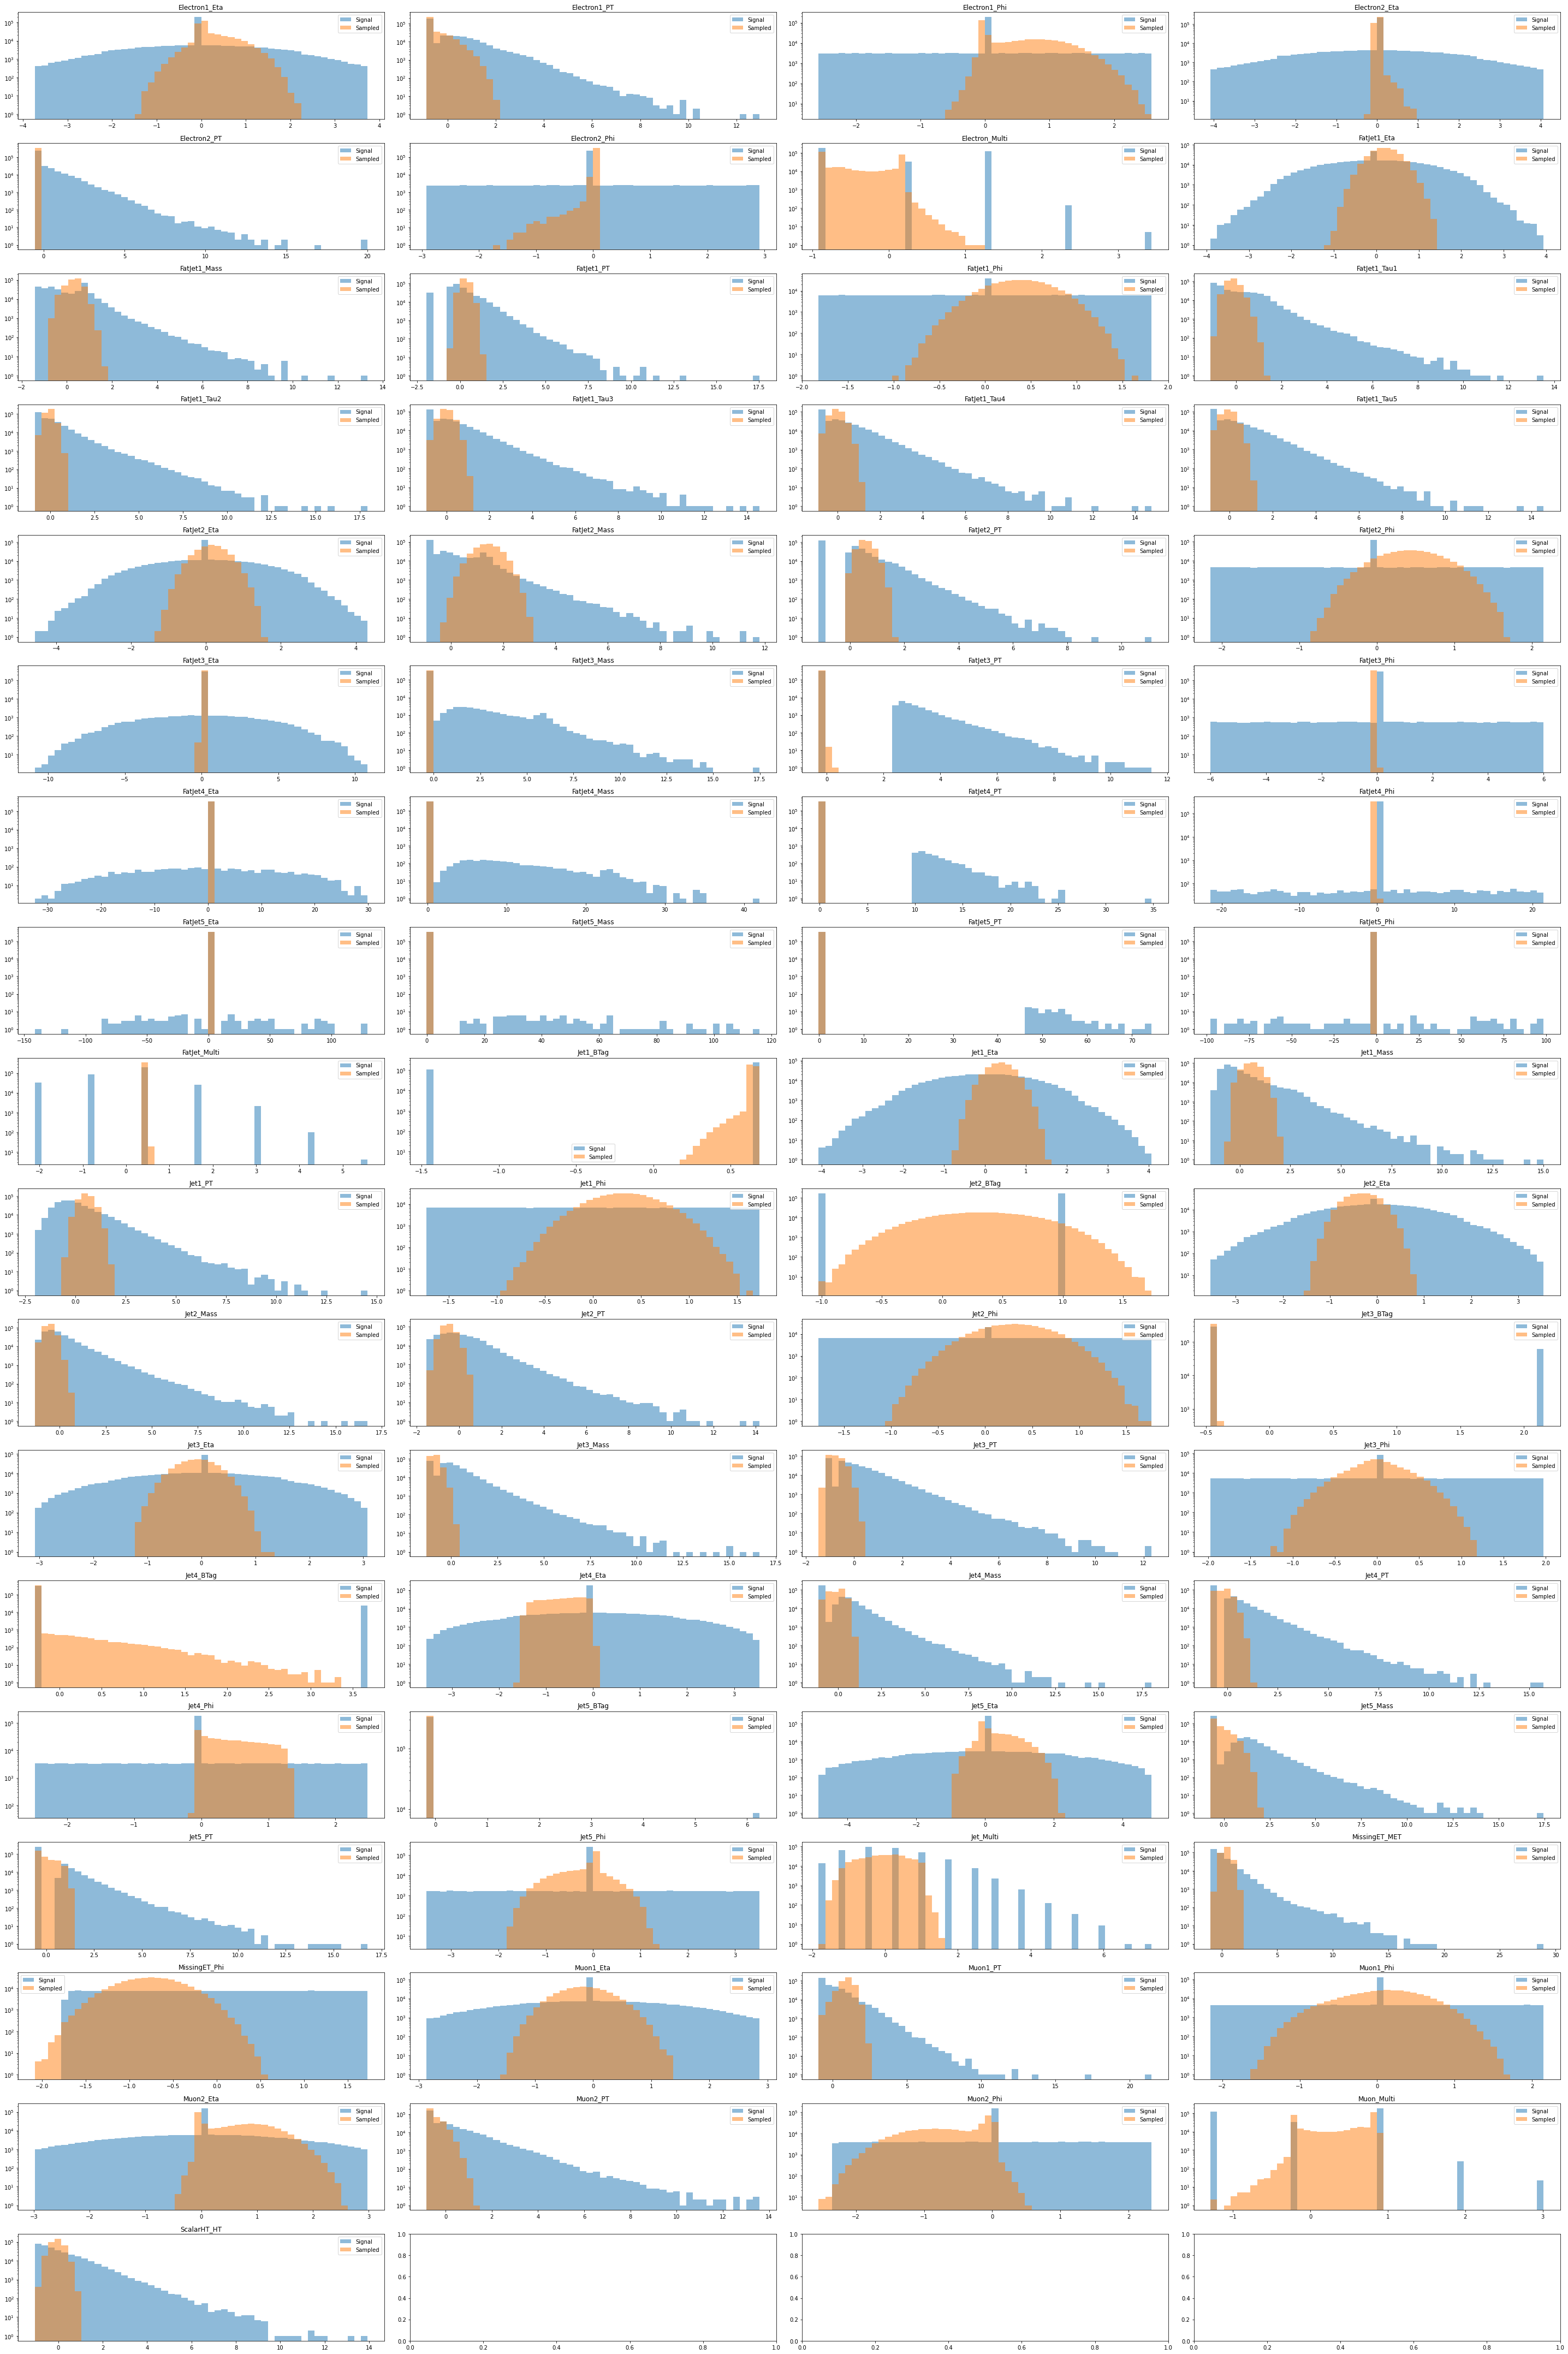

In [13]:
plot_graphs2(bkg, sample)

In [14]:
objective_score = 0
for idx in range(bkg.shape[1]):
    feature = bkg.columns[idx]
    if "Tag" in feature or "Multi" in feature:
        #print("Feature", feature, "é inteiro")
        objective_score += compare_integer(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
    else:
        #print("Feature", feature, "é continuo")
        objective_score += compare_continuous(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
print("WD Score:", objective_score)

WD Score: 15.832197051594719


## Bkg Data vs Reconstruction

In [15]:
def plot_graphs3(first, second, first_name="Signal", second_name="Sampled", bins=50, num_cols=4, num_features=69):

    R2_SCORE = 0

    # Reshape
    first = first.reshape(num_features, -1)
    second = second.reshape(num_features, -1)

    # Plot creation
    num_rows = int(np.ceil((num_features - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(range(num_features), total=num_features, desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(first[x].min(), second[x].min())
        hist_max = max(first[x].max(), second[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(first[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(second[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)

        x = x.cpu().numpy()
        output = output.cpu().numpy()

        #print("Input", np.isnan(x).any())
        #print("Output", np.isnan(output).any())


        R2_SCORE += r2_score(first[x],second[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    print("R2_SCORE:", R2_SCORE/num_features)

Processing...:   0%|          | 0/69 [00:00<?, ?it/s]

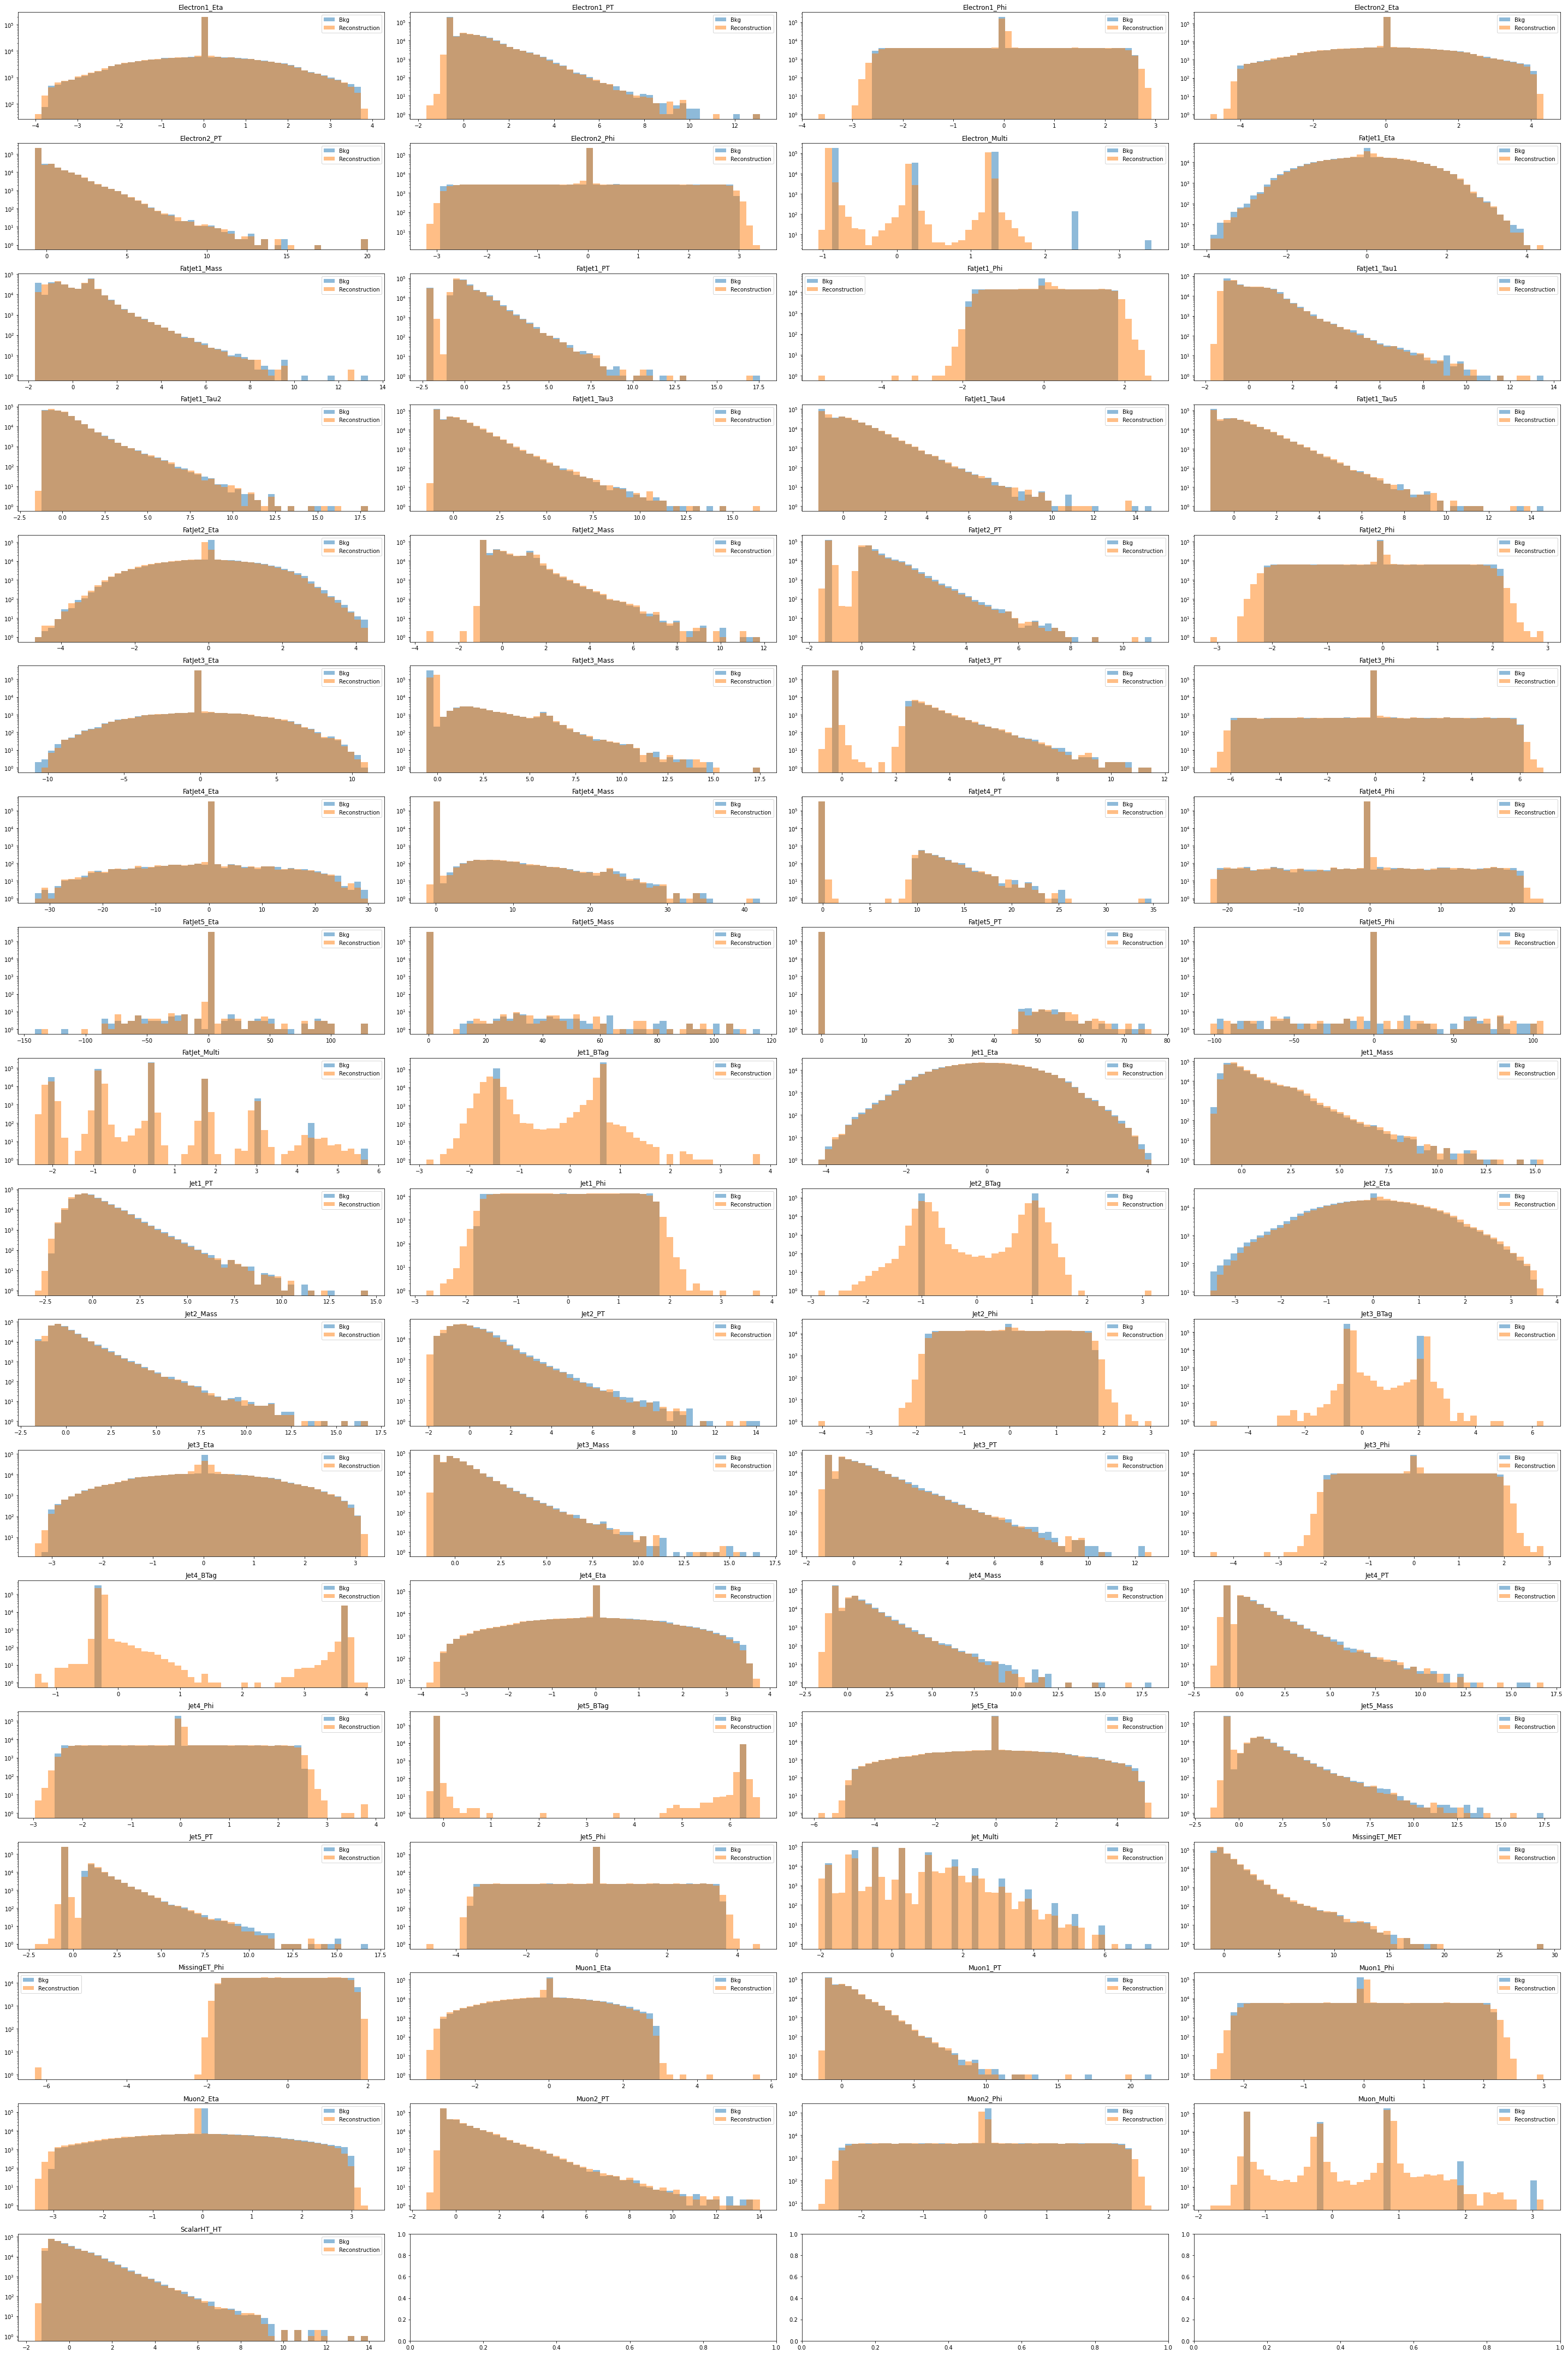

In [16]:
plot_graphs2(bkg, pd.DataFrame(x_out, columns=bkg.columns), first_name="Bkg", second_name="Reconstruction")

In [17]:
print("R2 Score:", r2_score(bkg.to_numpy(), x_out, sample_weight=bkg_weights.to_numpy()))

R2 Score: 0.9886068928790457


## Plot error distributions and ROC Score

Load data

In [18]:
bkg = _dataset(category='test',variant='bkg').all_data()
signal = _dataset(category='all',variant='signal').all_data()
# signal.drop(columns=['weights'], inplace=True)
signal['name'].unique()

array(['hg3000_hq1000.h5', 'wohg_hq1000.h5', 'hg3000_hq1200.h5',
       'wohg_hq1200.h5', 'fcnc.h5', 'hg3000_hq1400.h5', 'wohg_hq1400.h5'],
      dtype=object)

Plot

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve
def plot_graphs3(data, bins=50, num_cols=4):

    # Plot creation
    features = list(data['name'].unique())

    #num_rows = int(np.ceil((len(list(features)) - 1) / num_cols)) +1
    #fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    #i= 0


    distributions = {}

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        #row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        #i += 1

        # Input to the model
        sData = data.loc[data['name'] == x].drop(columns=['name', 'weights'])#[:100000]
        sData = torch.from_numpy(
            sData.to_numpy(dtype=np.float32)
        )

        # Pass input through model
        _, _, output, _ = model.test_step(sData)

        # Calculate the error dist
        error_dist = (sData - output)**2
        del output, sData
        error_dist = error_dist.detach().numpy().sum(axis=1)
        error_dist = np.log(error_dist)
        # Append to list
        distributions[x] = error_dist

    # Now we are going to find the maximum of all distributions
    max_of_dist = max(map(lambda x: max(x), distributions.values()))

    # Normalize the distributions
    # This way all values should be between 0 and one
    for x in distributions:
        distributions[x] = distributions[x] / max_of_dist
    # distributions =list(map(lambda x: x/max_of_dist, distributions))


    fig, ax = plt.subplots( figsize=(10,10))
    ax.set_yscale('log')

    

    for x in tqdm(distributions.keys(), desc="Processing..."):

        hist_range = (0, 1)        

        #x = x.replace(".h5", "")
        if x != 'bkg.h5':
            ax.hist(distributions[x], bins=bins, alpha=0.9, label=x.replace(".h5", ""), range=hist_range, histtype=u'step', linewidth=2)
        else:
            ax.hist(distributions[x], bins=bins, alpha=0.2, label=x.replace(".h5", ""), range=hist_range)

        # Plot rocs
        # ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)
        
    ax.autoscale(enable=True) 
    ax.set_title("Error Dist.")
    ax.legend()


    # PLOT ROC
    fig_roc, ax_roc = plt.subplots(figsize=(10,10))
    for x in tqdm(distributions.keys(), desc="Processing..."):
        if x != 'bkg.h5':
            # Set labels
            bkg_labels = np.zeros(distributions['bkg.h5'].shape[0]).astype(int)
            signal_labels = np.ones(distributions[x].shape[0]).astype(int)
            labels = np.concatenate([bkg_labels, signal_labels])

            weights = pd.concat([
                                data[data['name'] == "bkg.h5"]['weights'], 
                                data[data['name'] == x]['weights']
                                ])

            score = np.concatenate([distributions['bkg.h5'], distributions[x]]) 
            score = score / max_of_dist

            #print(labels.shape, weights.shape, score.shape, x)
            fpr, tpr, thr = roc_curve(
                    y_true=labels, 
                    y_score=score,
                    sample_weight=weights
                    )
            
            
            ax_roc.plot(fpr, tpr, label=x.replace('.h5', ''))
            ax_roc.plot([0,1],[0,1], 'k--')
   
            print(f"ROC SCORE for {x.replace('.h5', '')}:", 
                    roc_auc_score(y_true=labels, 
                    y_score=score,
                    sample_weight=weights))

    fig_roc.show()
    ax_roc.set_title(f"BKG vs Signals")
    ax_roc.legend()
                

    fig.tight_layout()
    plt.show()

In [20]:
data = pd.concat([signal, bkg])
del signal, bkg

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

ROC SCORE for hg3000_hq1000: 0.9996388108014527
ROC SCORE for wohg_hq1000: 0.9996462644584577
ROC SCORE for hg3000_hq1200: 0.9996545957878766
ROC SCORE for wohg_hq1200: 0.9996617643332472
ROC SCORE for fcnc: 0.9526880671465635
ROC SCORE for hg3000_hq1400: 0.9996559573774284
ROC SCORE for wohg_hq1400: 0.9996672617620437


<ipython-input-19-ec75de003e3a>:104: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



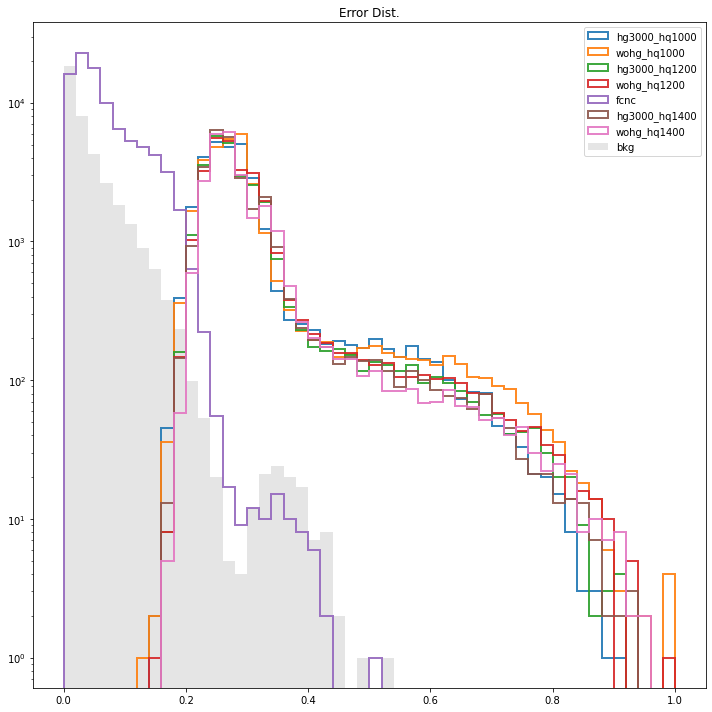

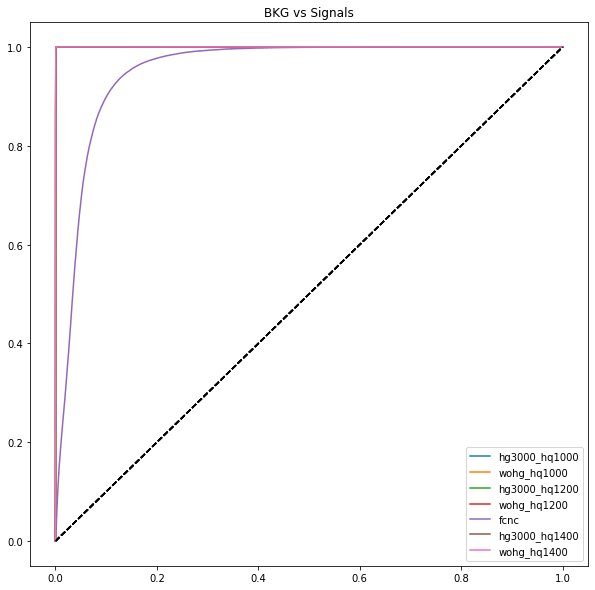

In [21]:
plot_graphs3(data)